# Project 1 - Generalized Linear Models with Gradient Descent

## Yan Bo Zeng

In [18]:
library(dplyr)
library(repr)
options(repr.plot.width = 12, repr.plot.height = 10)
options(scipen = 999)

# 1. Ordinary Least Squares

Recall the ordinary least squares model $y_i = x_i'\beta + \epsilon_i$. The maximum likelihood estimator (MLE) for the coefficient parameter $\beta$ is
\begin{align*}
    \hat{\beta} & = \arg\max_{\beta \in \mathbb{R}^k} -\frac{1}{2n} \sum_{i=1}^{n} \left(y_i - x_i'\beta \right)^2 \\
    & = \arg\min_{\beta \in \mathbb{R}^k} \frac{1}{2n} \sum_{i=1}^{n} \left(y_i - x_i'\beta \right)^2
\end{align*}

Denote $\frac{1}{2n} \sum_{i=1}^{n} \left(y_i - x_i'\beta \right)^2 = Q(\beta)$, $X$ as the model matrix including the intercept term, and $Y$ as the outcome vector. Then, the gradient is
\begin{align*}
    \nabla Q(\beta) & = \frac{\partial}{\partial\beta} Q(\beta) \\
    & = -\frac{1}{n} \sum_{i=1}^{n} \left(y_i - x_i'\beta \right)x_i \\
    & = -\frac{1}{n} X'\left(Y - X\beta \right)
\end{align*}

Thus, given a learning rate $\alpha_t$, gradient descent will iterate on
\begin{align*}
    \hat{\beta}_{t+1} & = \hat{\beta}_{t} - \alpha_t \nabla Q(\hat{\beta}_{t}) \\
    & = \hat{\beta}_{t} + \alpha_t \frac{1}{n} X'\left(Y - X\hat{\beta}_{t} \right)
\end{align*}

In [2]:
#Define the cost and gradient functions for OLS.
OLS_cost <- function(X, y, beta) {
    return(mean((y - X %*% beta)^2) / 2)
}

OLS_gradient <- function(X, y, beta) {
    return(-t(X) %*% (y - X %*% beta) / length(y))
}

In [3]:
#Define the gradient descent function.
gradient_descent <- function(X, y, beta_init = rep(0, ncol(X)), alpha = 0.01, num_iters = 2*10^4,
                             error_func = OLS_cost, grad_func = OLS_gradient, linesearch = FALSE, linesearch_c = 0.1) {
    
    #Record errors (cost values) from each iteration.
    error_history <- rep(0, num_iters)
    
    #Initialize beta.
    beta <- beta_init
    
    #Record alpha for line search.
    alpha_init <- alpha
    
    #Implement gradient descent.
    for (i in 1:num_iters) {
        error_old <- error_func(X, y, beta)
        delta <- grad_func(X, y, beta)
        beta <- beta - alpha * delta
        
        #Implement backtracking line search.
        if (linesearch == TRUE) {
            while (error_func(X, y, beta) > (error_old - linesearch_c*alpha*(norm(delta)^2))) {
                error_old <- error_func(X, y, beta)
                alpha = alpha / 2
                delta <- grad_func(X, y, beta)
                beta <- beta - alpha * delta
            }
            alpha <- alpha_init
        }
        
        error_history[i] <- error_func(X, y, beta)
    }
    
    #Return the history for plotting.
    return(list(beta, error_history))
}

## Test the algorithm on orange juice advertisement data.
Firstly, we can use the R built-in glm() package to obtain a robust estimate of the coefficients.

In [4]:
oj <- read.csv("C:/Users/yanbo/OneDrive/Stanford MS&E 311 Optimization/oj.csv")
X <- model.matrix(log(sales) ~ log(price) + brand, data = oj)
y <- log(oj$sales)

builtin <- glm(log(sales) ~ log(price) + brand, data = oj)
coef(builtin) %>% as.matrix()

(Intercept),10.8288216
log(price),-3.1386914
brandminute.maid,0.8701747
brandtropicana,1.5299428


Then, we can try different learning rates or use line search to find an effective one.

In [5]:
betalist001 <- gradient_descent(X, y)
betalist01 <- gradient_descent(X, y, alpha = 0.1)
betalist04 <- gradient_descent(X, y, alpha = 0.4)
betalist2 <- gradient_descent(X, y, alpha = 2)
betalist_ls <- gradient_descent(X, y, alpha = 2, linesearch = TRUE)

display <- cbind(betalist001[[1]], betalist01[[1]], betalist04[[1]], betalist2[[1]], betalist_ls[[1]])
colnames(display) <- c("alpha = 0.01", "alpha = 0.1", "alpha = 0.4", "alpha = 2", "alpha = 2, line search")
display

,alpha = 0.01,alpha = 0.1,alpha = 0.4,alpha = 2,"alpha = 2, line search"
(Intercept),10.8104335,10.8288216,10.8288216,NaN,10.8288216
log(price),-3.1016483,-3.1386914,-3.1386914,NaN,-3.1386914
brandminute.maid,0.8583812,0.8701747,0.8701747,NaN,0.8701747
brandtropicana,1.5083747,1.5299428,1.5299428,NaN,1.5299428


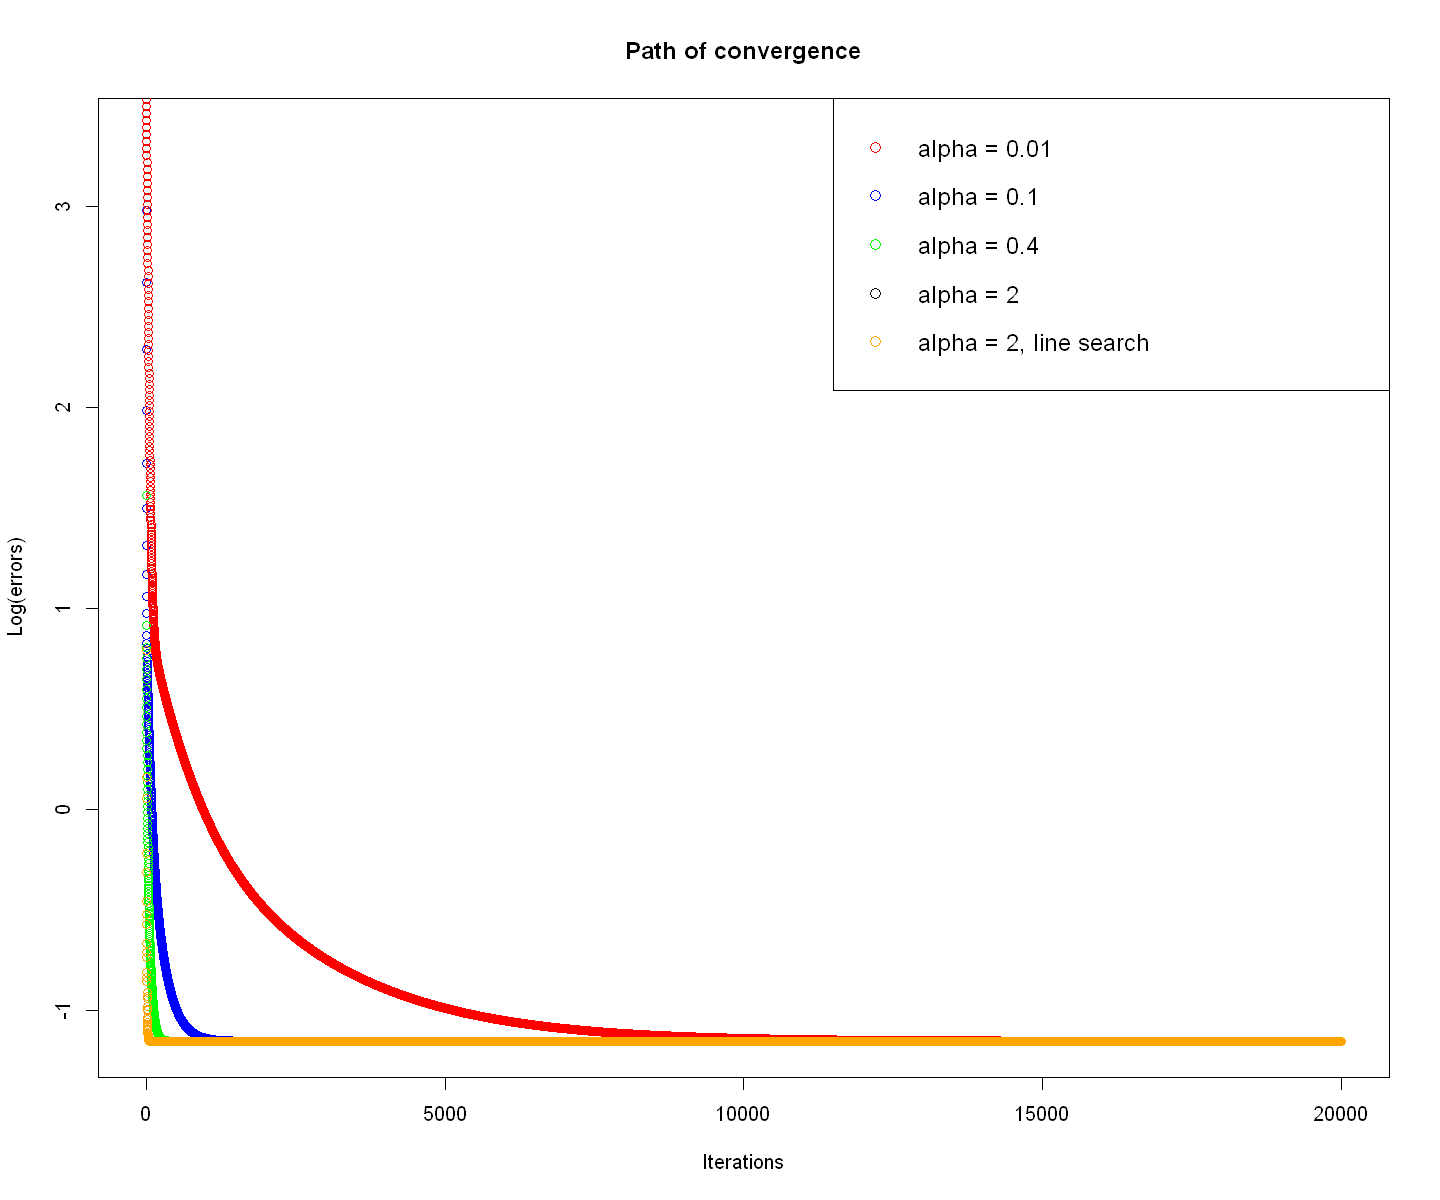

In [6]:
#Visualize the path of convergence.
plot(log(betalist01[[2]]), col = 'blue', main = 'Path of convergence', ylab = 'Log(errors)', xlab = 'Iterations')
points(log(betalist001[[2]]), col = 'red')
points(log(betalist04[[2]]), col = 'green')
points(log(betalist2[[2]]), col = 'black')
points(log(betalist_ls[[2]]), col = 'orange')
legend("topright", legend = c("alpha = 0.01", "alpha = 0.1", "alpha = 0.4", "alpha = 2", "alpha = 2, line search"),
       col = c("red", "blue", "green", "black", "orange"), bty = "o", pch = 1, cex = 1.2)

Here, using a learning rate of $0.01$ results in slow convergence, and therefore $\hat{\beta}$ cannot converge to the "correct" values within $20,000$ iterations. While learning rates of $0.1$ and $0.4$ perform very well, a learning rate of $2$ is too large, causing the algorithm to diverge and return NAs for all coefficients. On the other hand, the orange curve shows that line search is really helpful in finding a decent $\alpha_t$ for fast convergence and preventing the algorithm from blowing up.

# 2. Logistic and Probit Regressions

Recall that in logit and probit models, $\hat{\beta}$ is obtained by maximizing the log-likelihood function or equivalently minimizing the cross-entropy loss function.
\begin{align*}
    \hat{\beta} & = \arg\max_{\beta \in \mathbb{R}^k} \prod_{i=1}^{n} F(x_i'\beta)^{y_i} \left(1 - F(x_i'\beta) \right)^{1-y_i} \\
    & = \arg\min_{\beta \in \mathbb{R}^k} -\log{\left( \prod_{i=1}^{n} F(x_i'\beta)^{y_i} \left(1 - F(x_i'\beta) \right)^{1-y_i} \right)} \\
    & = \arg\min_{\beta \in \mathbb{R}^k} -\frac{1}{n} \sum_{i=1}^{n} \left(y_i\log{F(x_i'\beta)} + (1-y_i)\log{\left(1 - F(x_i'\beta) \right)} \right)
\end{align*}

Denote $-\frac{1}{n} \sum_{i=1}^{n} \left(y_i\log{F(x_i'\beta)} + (1-y_i)\log{\left(1 - F(x_i'\beta) \right)} \right) = Q(\beta)$. Then, the gradient is
\begin{align*}
    \nabla Q(\beta) & = \frac{\partial}{\partial\beta} Q(\beta) \\
    & = -\frac{1}{n} \sum_{i=1}^{n} \left(\frac{y_i}{F(x_i'\beta)} - \frac{1-y_i}{1-F(x_i'\beta)} \right) f(x_i'\beta)x_i \\
    & = -\frac{1}{n} \sum_{i=1}^{n} \frac{y_i-F(x_i'\beta)}{F(x_i'\beta) \left(1-F(x_i'\beta)\right)} f(x_i'\beta)x_i
\end{align*}

For logit, $F(x_i'\beta) = \frac{\exp{x_i'\beta}}{1+\exp{x_i'\beta}}$, and $f(x_i'\beta) = \left(\frac{\exp{x_i'\beta}}{1+\exp{x_i'\beta}} \right) \left(1 - \frac{\exp{x_i'\beta}}{1+\exp{x_i'\beta}} \right) = F(x_i'\beta) \left(1-F(x_i'\beta)\right)$.

For probit, $F(x_i'\beta) = \Phi(x_i'\beta)$, and $f(x_i'\beta) = \phi(x_i'\beta)$, where $\Phi(\cdot)$ and $\phi(\cdot)$ are the standard normal CDF and PDF, respectively.

In [7]:
#Define the cost and gradient functions for logit.
logit_cost <- function(X, y, beta) {
    return(-mean(y*log(exp(X%*%beta)/(1+exp(X%*%beta))) + (1-y)*log(1-exp(X%*%beta)/(1+exp(X%*%beta)))))
}

logit_gradient <- function(X, y, beta) {
    return(-t(X) %*% (y - exp(X%*%beta)/(1 + exp(X%*%beta))) / length(y))
}

## Test the algorithm for logit on synthetic data.

In [8]:
set.seed(888)
n <- 10000
y <- runif(n) > 0.4
X <- cbind(Intercept = rep(1, n), x1 = rnorm(n, 0, 2), x2 = runif(n, -2, 1), x3 = rnorm(n, 4, 1), x4 = rnorm(n, -3, 5))
data <- data.frame(y, X)

builtin <- glm(y ~ x1 + x2 + x3 + x4, data = data, family = binomial(link = "logit"))
coef(builtin) %>% as.matrix()

(Intercept),0.4161762124
x1,0.0090180079
x2,-0.0318122563
x3,-0.0014710907
x4,0.0008547123


In [9]:
betalist001 <- gradient_descent(X, y, error_func = logit_cost, grad_func = logit_gradient)
betalist01 <- gradient_descent(X, y, alpha = 0.1, error_func = logit_cost, grad_func = logit_gradient)
betalist04 <- gradient_descent(X, y, alpha = 0.4, error_func = logit_cost, grad_func = logit_gradient)
betalist08 <- gradient_descent(X, y, alpha = 0.8, error_func = logit_cost, grad_func = logit_gradient)
betalist_ls <- gradient_descent(X, y, alpha = 0.8, linesearch = TRUE, linesearch_c = 0.3,
                                error_func = logit_cost, grad_func = logit_gradient)

display <- cbind(betalist001[[1]], betalist01[[1]], betalist04[[1]], betalist08[[1]], betalist_ls[[1]])
colnames(display) <- c("alpha = 0.01", "alpha = 0.1", "alpha = 0.4", "alpha = 0.8", "alpha = 0.8, line search")
display

,alpha = 0.01,alpha = 0.1,alpha = 0.4,alpha = 0.8,"alpha = 0.8, line search"
Intercept,0.3849996501,0.4161762124,0.36384440,0.48927135,0.4161762121
x1,0.0091000374,0.0090180079,0.01458780,0.02144048,0.0090180079
x2,-0.0330762659,-0.0318122563,-0.03679878,-0.06163636,-0.0318122561
x3,0.0055857081,-0.0014710907,-0.11527211,-0.06805416,-0.0014710922
x4,0.0006474896,0.0008547123,0.19756067,0.20937828,0.0008547152


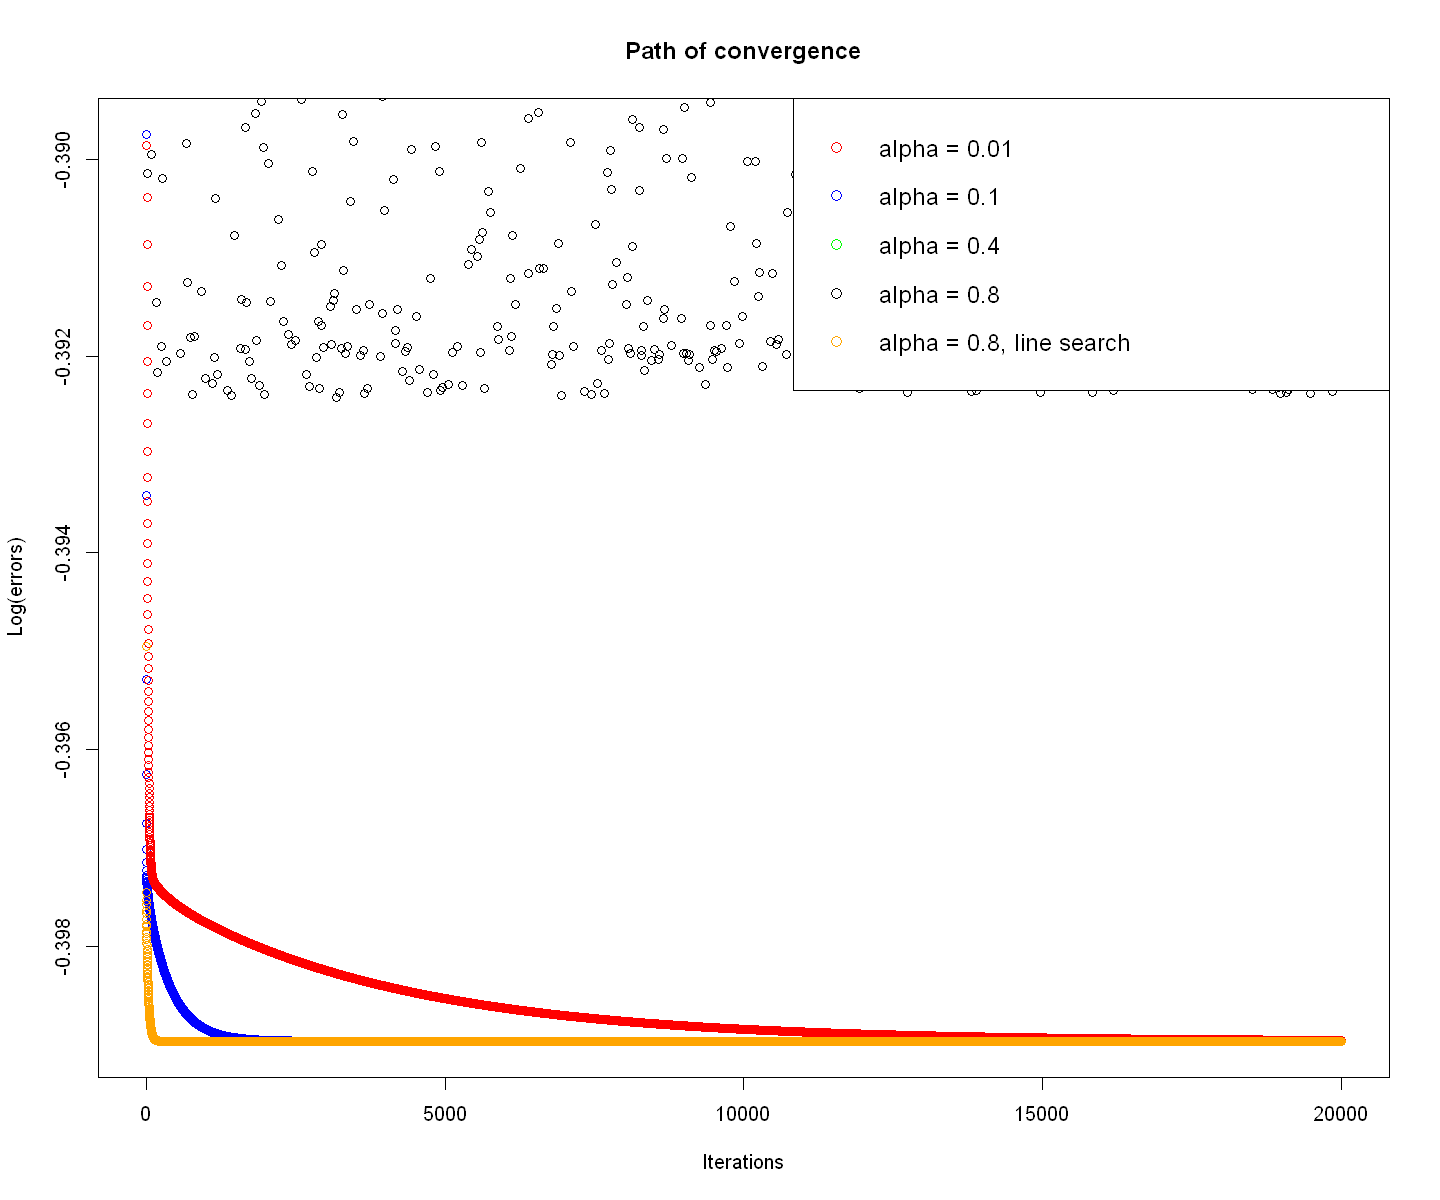

In [10]:
#Visualize the path of convergence.
plot(log(betalist01[[2]]), col = 'blue', main = 'Path of convergence', ylab = 'Log(errors)', xlab = 'Iterations')
points(log(betalist001[[2]]), col = 'red')
points(log(betalist04[[2]]), col = 'green')
points(log(betalist08[[2]]), col = 'black')
points(log(betalist_ls[[2]]), col = 'orange')
legend("topright", legend = c("alpha = 0.01", "alpha = 0.1", "alpha = 0.4", "alpha = 0.8", "alpha = 0.8, line search"),
       col = c("red", "blue", "green", "black", "orange"), bty = "o", pch = 1, cex = 1.2)

In the logistic regression case, gradient descent converges slowly when using a learning rate of $0.01$, although we can see that it is on the right track. The algorithm diverges when the learning rate is $0.4$, and it begins bouncing around if we further increase the learning rate to $0.8$. After trying out different rates, we find that $\alpha_t = 0.1$ works the best. However, if we include the time for testing various $\alpha_t$'s, line search with an initial $\alpha_t = 0.8$ takes the least amount of time to obtain the correct estimates.

## Test the algorithm for probit.

In [11]:
#Define the cost and gradient functions for probit.
probit_cost <- function(X, y, beta) {
    return(-mean(y*log(pnorm(X%*%beta)) + (1-y)*log(1-pnorm(X%*%beta))))
}

probit_gradient <- function(X, y, beta) {
    return(-t(X) %*% ((y-pnorm(X%*%beta))/(pnorm(X%*%beta)*(1-pnorm(X%*%beta)))*dnorm(X%*%beta)) / length(y))
}

In [12]:
builtin <- glm(y ~ x1 + x2 + x3 + x4, data = data, family = binomial(link = "probit"))
coef(builtin) %>% as.matrix()

(Intercept),0.2599022393
x1,0.0055922210
x2,-0.0197340040
x3,-0.0008900177
x4,0.0005318751


In [13]:
betalist001 <- gradient_descent(X, y, error_func = probit_cost, grad_func = probit_gradient)
betalist01 <- gradient_descent(X, y, alpha = 0.1, error_func = probit_cost, grad_func = probit_gradient)
betalist02 <- gradient_descent(X, y, alpha = 0.2, error_func = probit_cost, grad_func = probit_gradient)
betalist_ls <- gradient_descent(X, y, alpha = 0.2, linesearch = TRUE, linesearch_c = 0.3,
                                error_func = probit_cost, grad_func = probit_gradient)

display <- cbind(betalist001[[1]], betalist01[[1]], betalist02[[1]], betalist_ls[[1]])
colnames(display) <- c("alpha = 0.01", "alpha = 0.1", "alpha = 0.2", "alpha = 0.2, line search")
display

,alpha = 0.01,alpha = 0.1,alpha = 0.2,"alpha = 0.2, line search"
Intercept,0.2595536275,NaN,NaN,0.2599022390
x1,0.0055931789,NaN,NaN,0.0055922211
x2,-0.0197482465,NaN,NaN,-0.0197340041
x3,-0.0008111348,NaN,NaN,-0.0008900179
x4,0.0005295480,NaN,NaN,0.0005318755


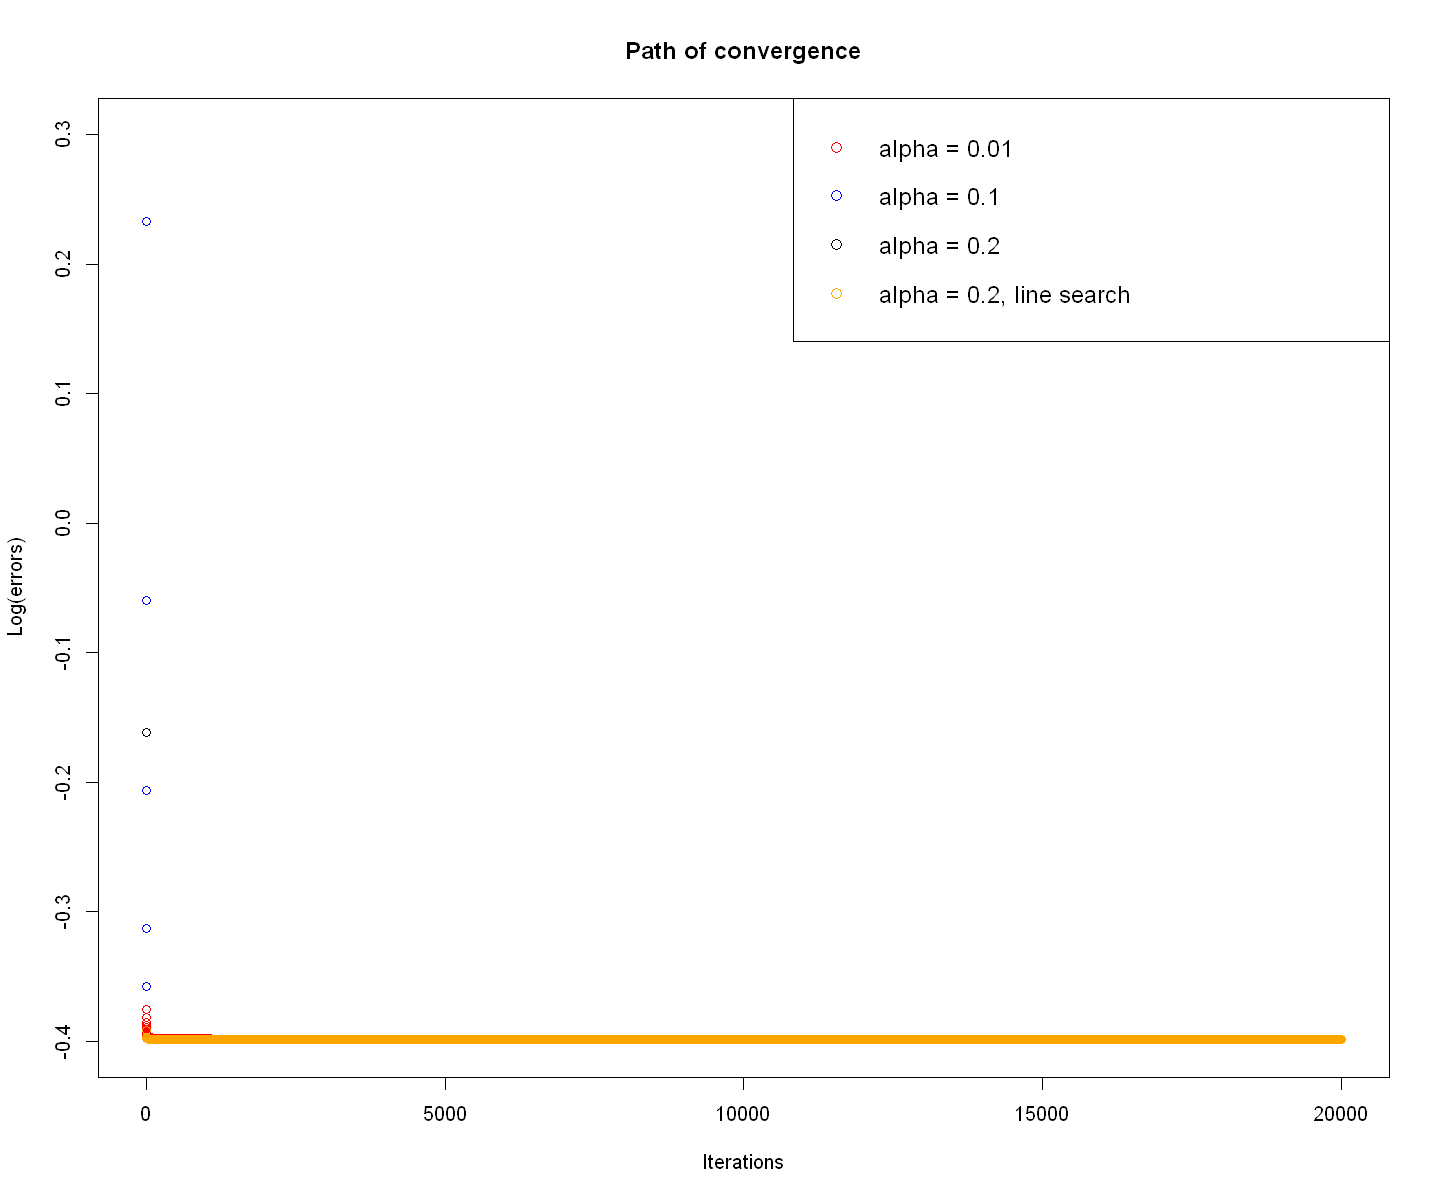

In [14]:
#Visualize the path of convergence.
plot(log(betalist01[[2]]), col = 'blue', main = 'Path of convergence', ylab = 'Log(errors)', xlab = 'Iterations',
     ylim = c(-0.4, 0.3))
points(log(betalist001[[2]]), col = 'red')
points(log(betalist02[[2]]), col = 'black')
points(log(betalist_ls[[2]]), col = 'orange')
legend("topright", legend = c("alpha = 0.01", "alpha = 0.1", "alpha = 0.2", "alpha = 0.2, line search"),
       col = c("red", "blue", "black", "orange"), bty = "o", pch = 1, cex = 1.2)

Compared with the logit model, gradient descent for probit suffers more from numeric overflow or underflow due to the way R computes the standard normal densities (easy to get $1$ or $0$). Consequently, a learning rate of $0.1$ appears to be large enough for the algorithm to diverge. We have to use a small $\alpha_t = 0.01$ to ensure convergence. When we have little prior knowledge about what learning rate to use, line search can still be useful in the probit case.

## Gradient descent might not work well with logit or probit models on economics data.
Here we try to apply the gradient descent algorithm to fit a logit and a probit model on the 1970s German creditworthiness data ($n = 1000$ creditors).

In [15]:
repayment <- read.csv("C:/Users/yanbo/OneDrive/Stanford MS&E 311 Optimization/repayment.csv")
X <- model.matrix(repaid ~ age + telephone + amount + duration, data = repayment)
y <- repayment$repaid

### Try logit.

In [16]:
logit <- glm(repaid ~ age + telephone + amount + duration, data = repayment, family = binomial(link = "logit"))
betalist0001 <- gradient_descent(X, y, alpha = 0.001, error_func = logit_cost, grad_func = logit_gradient)
betalist001 <- gradient_descent(X, y, error_func = logit_cost, grad_func = logit_gradient)
betalist01 <- gradient_descent(X, y, alpha = 0.1, error_func = logit_cost, grad_func = logit_gradient)
betalist02 <- gradient_descent(X, y, alpha = 0.2, error_func = logit_cost, grad_func = logit_gradient)
opt <- optim(par = rep(0, ncol(X)), fn = logit_cost, gr = logit_gradient, y = y, X = X, method = "BFGS")

display <- cbind(coef(logit), opt$par, betalist0001[[1]], betalist001[[1]], betalist01[[1]], betalist02[[1]])
colnames(display) <- c("glm()", "optim(), BFGS", "alpha = 0.001", "alpha = 0.01", "alpha = 0.1", "alpha = 0.2")
display

,glm(),"optim(), BFGS",alpha = 0.001,alpha = 0.01,alpha = 0.1,alpha = 0.2
(Intercept),1.003682766,1.00381596723,NaN,NaN,NaN,NaN
age,0.016736147,0.01674953954,NaN,NaN,NaN,NaN
telephone,0.336726184,0.33632523323,NaN,NaN,NaN,NaN
amount,-0.000045302,-0.00004526219,NaN,NaN,NaN,NaN
duration,-0.033050297,-0.03308053324,NaN,NaN,NaN,NaN


### Try probit.

In [17]:
probit <- glm(repaid ~ age + telephone + amount + duration, data = repayment, family = binomial(link = "probit"))
betalist0001 <- gradient_descent(X, y, alpha = 0.001, error_func = probit_cost, grad_func = probit_gradient)
betalist001 <- gradient_descent(X, y, error_func = probit_cost, grad_func = probit_gradient)
betalist01 <- gradient_descent(X, y, alpha = 0.1, error_func = probit_cost, grad_func = probit_gradient)
betalist02 <- gradient_descent(X, y, alpha = 0.2, error_func = probit_cost, grad_func = probit_gradient)
opt <- optim(par = rep(0, ncol(X)), fn = probit_cost, gr = probit_gradient, y = y, X = X, method = "BFGS")

display <- cbind(coef(probit), opt$par, betalist0001[[1]], betalist001[[1]], betalist01[[1]], betalist02[[1]])
colnames(display) <- c("glm()", "optim(), BFGS", "alpha = 0.001", "alpha = 0.01", "alpha = 0.1", "alpha = 0.2")
display

,glm(),"optim(), BFGS",alpha = 0.001,alpha = 0.01,alpha = 0.1,alpha = 0.2
(Intercept),0.62832653262,0.61845846081,NaN,NaN,NaN,NaN
age,0.00988129226,0.00989370816,NaN,NaN,NaN,NaN
telephone,0.20658626188,0.20330306818,NaN,NaN,NaN,NaN
amount,-0.00002915846,-0.00002866031,NaN,NaN,NaN,NaN
duration,-0.02001453860,-0.01972733973,NaN,NaN,NaN,NaN


My gradient descent algorithm does not converge on the 1970s German creditworthiness data even with a super small learning rate of $0.001$. Line search, in this case, fails to generate non-NA gradient. In contrast, R optim(), a general-purpose optimizer (minimizer) based on the BFGS and L-BFGS-B algorithms, can return some decent estimates if we employ the BFGS option. Inspired by this, for Project 2, I aim to code up a quasi-Newton-based optimizer that can successfully fit a logit and a probit model on this dataset.